# TODO: Document
# TODO: Cleanup
* Note, this script may take several days to run

In [1]:
# CHANGE THIS PARAMETER
username = "taapaye"

In [28]:
import functools
import os
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm


@functools.wraps(smf.ols)
def lm(*args, **kwargs):
    return smf.ols(*args, **kwargs).fit()

In [3]:
np.random.seed(0)

In [35]:
os.chdir(f"../../data/recommendations/{username}")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/recommendations/taapaye'

In [5]:
filtered_df = pickle.load(open("../../processed_data/user_anime_lists.pkl", "rb"))
user_df = pickle.load(open("user_anime_list.pkl", "rb"))
filtered_df = filtered_df.loc[lambda x: ~x["username"].isin(user_df.username)]
filtered_df = pd.concat([filtered_df, user_df], ignore_index=True)
filtered_df = filtered_df.set_index("username")

In [6]:
@functools.lru_cache()
def get_item_corrs(nonneg_corrs=False):
    corrs = pickle.load(open("../../processed_data/item_correlations.pkl", "rb"))
    if nonneg_corrs:
        corrs["similarity"] = corrs["corr"]
    else:
        corrs["similarity"] = corrs["corr"].abs()
    corrs = corrs.dropna()
    corrs = corrs.loc[
        lambda x: x.index.get_level_values("anime_id_x")
        != x.index.get_level_values("anime_id_y")
    ]
    corrs = corrs.sort_values(by="similarity")
    return corrs


def get_item_corrs_wrapper(df, username):
    return get_item_corrs()


def get_item_scores(df, corrs, username, neighborhood_size):
    corrs = corrs.groupby("anime_id_x").tail(neighborhood_size)
    score = df.loc[username].merge(
        corrs.reset_index("anime_id_x"), left_on="anime_id", right_on="anime_id_y",
    )
    score = score.drop("anime_id", axis=1).rename({"anime_id_x": "anime_id"}, axis=1)
    return score

In [7]:
def get_user_corrs(df, username, nonneg_corrs=False):
    user_subset = df.loc[[username]].merge(df.reset_index(), on="anime_id")
    corr_numerator = user_subset.groupby("username").apply(
        lambda x: np.dot(x["score_x"], x["score_y"])
    )
    corr_denom = df.groupby("username").apply(
        lambda x: np.sqrt(np.dot(x["score"], x["score"]))
    )
    corr_denom *= corr_denom.loc[username]
    corrs = pd.DataFrame((corr_numerator / corr_denom), columns=["corr"])
    if nonneg_corrs:
        corrs["similarity"] = corrs["corr"]
    else:
        corrs["similarity"] = corrs["corr"].abs()
    corrs["corr_size"] = user_subset.groupby("username").size()
    corrs = corrs.drop(username)
    corrs = corrs.dropna()
    corrs = corrs.loc[lambda x: x["corr_size"] > 2]
    corrs = corrs.sort_values(by="similarity")
    return corrs


def get_user_scores(df, corrs, recommendee, neighborhood_size):
    corrs = corrs[-neighborhood_size:]
    score = (df.merge(pd.DataFrame(corrs), on="username")).dropna()
    return score

In [8]:
def get_delta(score):
    return score.groupby("anime_id").apply(
        lambda x: np.dot(x["score"], x["corr"]) / x["corr"].abs().sum()
    )

In [9]:
def get_squared_error(df, pred_df, username):
    pred_df = pred_df.loc[pred_df.index.intersection(df.loc[username].anime_id)]
    pred_df = pred_df.merge(
        df.loc[username].set_index("anime_id")["score"], on="anime_id"
    )
    errors = pred_df["pred_score"] - pred_df["score"]
    return np.dot(errors, errors)

In [10]:
def compute_accuracy_metrics(
    is_df, oos_df, score_fn, corrs_fn, username, neighborhood_sizes,
):
    corrs = corrs_fn(is_df, username)
    metrics = pd.DataFrame()
    for neighborhood_size in tqdm(
        reversed(sorted(neighborhood_sizes)),
        total=len(neighborhood_sizes),
        position=1,
        leave=True,
    ):
        score = score_fn(is_df, corrs, username, neighborhood_size)
        pred_df = pd.DataFrame()
        pred_df["delta"] = get_delta(score)

        # train linear model
        seen_shows = is_df.loc[username].merge(pred_df, on=["anime_id"])
        model = lm("score ~ delta + 0", seen_shows)

        # inference
        pred_df["pred_score"] = model.predict(pred_df)
        is_pred_df = pred_df.loc[lambda x: x.index.isin(is_df.loc[username].anime_id)]
        oos_pred_df = pred_df.loc[lambda x: x.index.isin(oos_df.anime_id)]

        # compute coverage
        is_coverage = len(is_pred_df) / len(is_df.loc[username])
        oos_coverage = len(oos_pred_df) / len(oos_df)

        # compute rmse
        missing_is = is_df.loc[username].loc[
            lambda x: ~x.anime_id.isin(is_pred_df.index)
            & ~x.anime_id.isin(oos_df.anime_id)
        ]
        missing_oos = oos_df.loc[lambda x: ~x.anime_id.isin(oos_pred_df.index)]
        is_se = get_squared_error(is_df, is_pred_df, username)
        oos_se = get_squared_error(oos_df, oos_pred_df, username)
        missing_is_se = np.dot(missing_is["score"], missing_is["score"])
        missing_oos_se = np.dot(missing_oos["score"], missing_oos["score"])
        is_rmse = np.sqrt((is_se + missing_is_se) / len(is_df.loc[username]))
        oos_rmse = np.sqrt((oos_se + missing_oos_se) / len(oos_df))
        metrics = metrics.append(
            {
                "neighborhood_size": neighborhood_size,
                "is_rmse": is_rmse,
                "is_coverage": is_coverage,
                "oos_rmse": oos_rmse,
                "oos_coverage": oos_coverage,
            },
            ignore_index=True,
        )

    return metrics

In [11]:
K = 10
base = np.sqrt(2)

errors_by_neighborhood_size = []
max_size = len(filtered_df.anime_id.unique())
neighborhood_sizes = [
    int(base ** i) for i in range(int(np.log(max_size) / np.log(base)) + 1)
] + [max_size]
neighborhood_sizes = sorted(list(set(neighborhood_sizes)))
splits = np.array_split(filtered_df.loc[username].sample(frac=1), K)

for split in tqdm(splits, total=len(splits), position=0, leave=True):
    oos_df = split
    is_df = filtered_df.loc[
        lambda x: ~(
            (x.index.get_level_values("username") == username)
            & x.anime_id.isin(oos_df.anime_id)
        )
    ]

    user_metrics = compute_accuracy_metrics(
        is_df.copy(),
        oos_df.copy(),
        get_user_scores,
        get_user_corrs,
        username,
        neighborhood_sizes,
    )
    user_metrics["signal"] = "user"
    errors_by_neighborhood_size.append(user_metrics)

    item_metrics = compute_accuracy_metrics(
        is_df.copy(),
        oos_df.copy(),
        get_item_scores,
        get_item_corrs_wrapper,
        username,
        neighborhood_sizes,
    )
    item_metrics["signal"] = "item"
    errors_by_neighborhood_size.append(item_metrics)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [12]:
allerrors = pd.concat(errors_by_neighborhood_size, ignore_index=True)

In [13]:
allerrors

,is_coverage,is_rmse,neighborhood_size,oos_coverage,oos_rmse,signal
0,0.877493,0.969957,13866.0,0.952381,1.436722,user
1,0.877493,0.971884,11585.0,0.952381,1.438658,user
2,0.877493,0.981388,8192.0,0.952381,1.457245,user
3,0.877493,0.993017,5792.0,0.952381,1.483421,user
4,0.877493,1.003001,4096.0,0.952381,1.489987,user
...,...,...,...,...,...,...
535,0.815864,1.315860,8.0,0.829268,1.486379,item
536,0.776204,1.351920,5.0,0.756098,1.532542,item
537,0.747875,1.362714,4.0,0.756098,1.540668,item
538,0.645892,1.317501,2.0,0.682927,1.569581,item


## Visualizations

In [14]:
wide_data = pd.melt(allerrors, ["neighborhood_size", "signal"])

In [15]:
wide_data

,neighborhood_size,signal,variable,value
0,13866.0,user,is_coverage,0.877493
1,11585.0,user,is_coverage,0.877493
2,8192.0,user,is_coverage,0.877493
3,5792.0,user,is_coverage,0.877493
4,4096.0,user,is_coverage,0.877493
...,...,...,...,...
2155,8.0,item,oos_rmse,1.486379
2156,5.0,item,oos_rmse,1.532542
2157,4.0,item,oos_rmse,1.540668
2158,2.0,item,oos_rmse,1.569581


In [16]:
for signal in wide_data["signal"].unique():
    wide_data.loc[lambda x: x["signal"] == signal, "variable"] = (
        f"{signal}_" + wide_data.loc[lambda x: x["signal"] == signal, "variable"]
    )

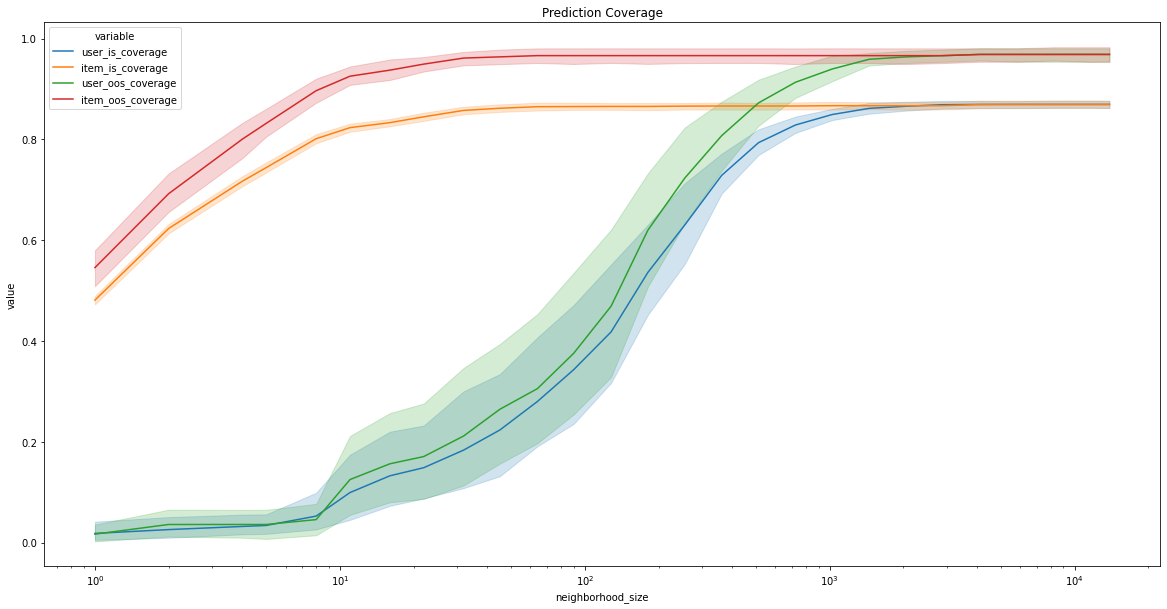

In [17]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("coverage")],
).set(xscale="log", title="Prediction Coverage")

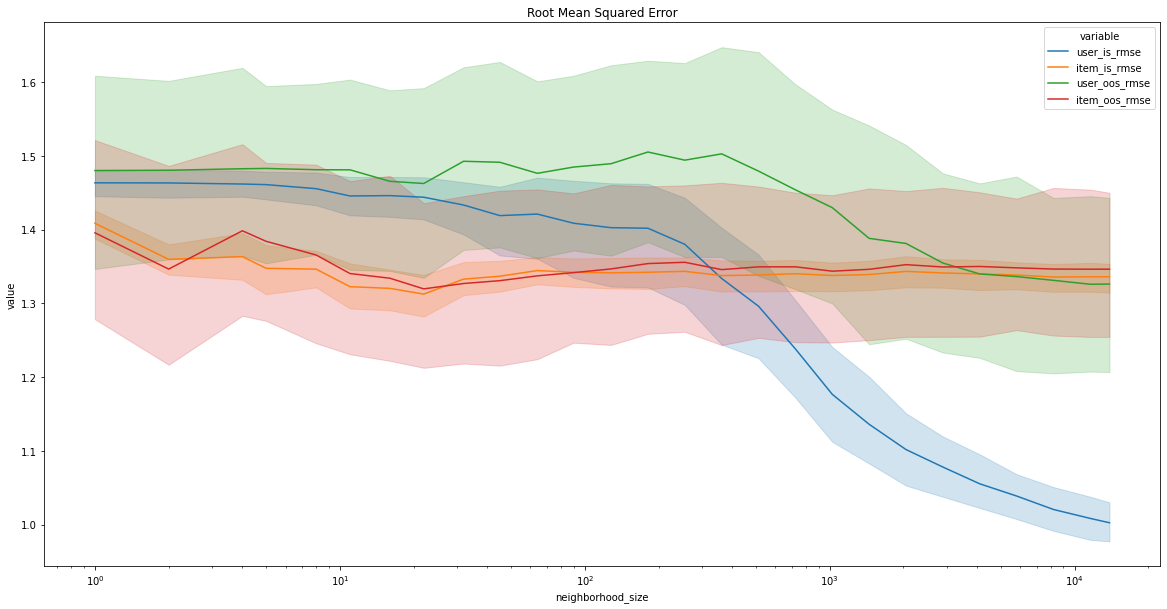

In [18]:
plt.figure(figsize=(20, 10))
_ = sns.lineplot(
    x="neighborhood_size",
    y="value",
    hue="variable",
    data=wide_data.loc[lambda x: x.variable.str.contains("rmse")],
).set(xscale="log", title="Root Mean Squared Error")

In [32]:
allerrors.groupby(["signal", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).head(20)

is_coverage   is_rmse  oos_coverage  oos_rmse
signal neighborhood_size                                               
item   22.0                  0.845026  1.312511      0.949593  1.319579
user   11585.0               0.869603  1.008359      0.968815  1.325848
       13866.0               0.869603  1.002483      0.968815  1.326118
item   32.0                  0.857733  1.332803      0.961614  1.326879
       45.0                  0.861976  1.336761      0.963995  1.330726
user   8192.0                0.869603  1.020482      0.968815  1.331160
item   16.0                  0.833434  1.320297      0.937631  1.334047
user   5792.0                0.869603  1.038750      0.968815  1.336242
item   64.0                  0.865085  1.344426      0.966434  1.337242
user   4096.0                0.869603  1.055309      0.968815  1.339833
item   11.0                  0.823550  1.322576      0.925610  1.340377
       90.0                  0.865363  1.342104      0.966434  1.341617
       1024.0                0.867062  1.337715      0.966434  1.343582
       362.0                 0.866490  1.337583      0.966434  1.345704
       1448.0                0.867062  1.339013      0.966434  1.346103
       11585.0               0.869603  1.335970      0.968815  1.346263
       13866.0               0.869603  1.335971      0.968815  1.346301
       2.0                   0.623401  1.359653      0.692451  1.346446
       8192.0                0.869603  1.335653      0.968815  1.346463
       128.0                 0.865642  1.341330      0.966434  1.346656

## Store best hyperparameters

In [24]:
allerrors.groupby(["signal", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).reset_index().groupby("signal").first()

,neighborhood_size,is_coverage,is_rmse,oos_coverage,oos_rmse
signal,,,,,
item,22.0,0.845026,1.312511,0.949593,1.319579
user,11585.0,0.869603,1.008359,0.968815,1.325848


In [38]:
outdir = "hyperparameters"
if not os.path.exists(outdir):
    os.mkdir(outdir)
os.chdir(outdir)

In [41]:
allerrors.groupby(["signal", "neighborhood_size"]).mean().sort_values(
    by="oos_rmse"
).reset_index().groupby("signal").first().to_pickle("neighborhoodcf.best.pkl")
allerrors.to_pickle("neighborhoodcf.all.pkl")